In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate
from scipy.spatial.distance import cdist

# Προετοιμασία δεδομένων.

Διαγραφή της στήλης timestamp απο τον πίνακα ratings (αρχείο u.data) και εισαγωγή ονομάτων στις στήλες για κάθε σύνολο δεδομένων.

In [3]:
movies = pd.read_csv('ml-latest-small-100K/movies.csv')

ratings = pd.read_csv('ml-latest-small-100K/ratings.csv')
ratings = ratings.drop('timestamp', axis=1)

Στο σετ δεδομένων movies (u.item), υπάρχουν οι στήλες:

*['movie_id', 'title', 'release_date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']*,

αλλα εμείς κρατάμε μόνο τις στήλες *[movie_id και title]*, μιας και είναι οι μόνες που χρειάζονται στον αλγόριθμο **Collaborative Filtering**

In [4]:
print(movies)
print(f"\nΣύνολο διαφορετικών ταινιών στο Dataset: {len(movies)}.")
movies[movies['movieId'] == 318].head()

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama


Στο σετ δεδομένων ratings (u.data), υπάρχουν οι βαθμολογίες του κάθε χρήστη για τις ταινίες.

In [5]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Ένωση πινάκων **ratings** και **movies** με άξονα το **movie_id**.

In [6]:
dataset = pd.merge(ratings, movies, on="movieId")
dataset.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Ψάχνοντας στην ένωση πινάκων, μπορούμε να δούμε ο,τι ο χρήστης **611**, βαθμολόγησε τη ταινία με όνομα: *Interstellar (2014)*, με **5/5**.

Επίσης μπορούμε να δούμε οτι ο βαθμολόγησε άλλες 10 ταινίες.

In [7]:
movie_title_to_explore = "Interstellar (2014)"
dataset[(dataset['title'] == movie_title_to_explore) & (dataset['userId'] == 611)]

,userId,movieId,rating,title,genres
100836,611,109487,5.0,Interstellar (2014),Sci-Fi|IMAX


In [8]:
dataset[(dataset['userId'] == 611)].head(10)

,userId,movieId,rating,title,genres
100836,611,109487,5.0,Interstellar (2014),Sci-Fi|IMAX
100837,611,134130,5.0,The Martian (2015),Adventure|Drama|Sci-Fi
100838,611,135569,4.0,Star Trek Beyond (2016),Action|Adventure|Sci-Fi
100839,611,166528,5.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
100840,611,179819,3.0,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi
100841,611,187595,4.0,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi
100842,611,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
100843,611,89745,4.0,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
100844,611,122892,5.0,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
100845,611,122916,3.0,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi


In [9]:
print(f"Μέση βαθμολογία για την ταινία: {movie_title_to_explore}.\n{dataset[(dataset['title'] == movie_title_to_explore)]['rating'].mean()}")

Μέση βαθμολογία για την ταινία: Interstellar (2014).
4.006756756756757


In [10]:
dataset['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Matrix, The (1999)                           279
Silence of the Lambs, The (1991)             279
Star Wars: Episode IV - A New Hope (1977)    252
Jurassic Park (1993)                         239
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            225
Schindler's List (1993)                      220
Name: count, dtype: int64

# Εξερεύνηση Δεδομένων

In [11]:
complete_movie_stats = dataset.groupby('title')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
complete_movie_stats.head(10)

,count,mean
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Matrix, The (1999)",279,4.193548
"Silence of the Lambs, The (1991)",279,4.161290
Star Wars: Episode IV - A New Hope (1977),252,4.234127
Jurassic Park (1993),239,3.751046
Braveheart (1995),237,4.031646
Terminator 2: Judgment Day (1991),225,3.975556


In [12]:
complete_movie_stats[(complete_movie_stats['count'] >= 100)][0:10]

,count,mean
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Matrix, The (1999)",279,4.193548
"Silence of the Lambs, The (1991)",279,4.161290
Star Wars: Episode IV - A New Hope (1977),252,4.234127
Jurassic Park (1993),239,3.751046
Braveheart (1995),237,4.031646
Terminator 2: Judgment Day (1991),225,3.975556


Όπως βλέπουμε, οι χρήστες είναι αρκετά γενναιόδωροι στις βαθμολογίες, με την υψηλότερη βαθμολογία (**5**) να είναι τρίτη στην κατάταξη, ως σύνολο καταγεγραμμένων βαθμολογιών για κάθε ταινία.

Κατανομή Βαθμολογίας: 
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7552
2.5     5550
3.0    20053
3.5    13138
4.0    26837
4.5     8565
5.0    13229
Name: count, dtype: int64


/tmp/ipykernel_3471/166334091.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(dataset, x='rating', palette='flare')


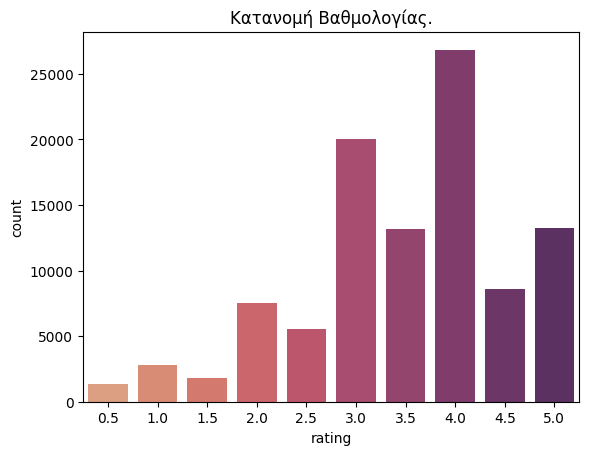

In [13]:
print(f"Κατανομή Βαθμολογίας: \n{dataset['rating'].value_counts().sort_index(ascending=True)}")

sns.countplot(dataset, x='rating', palette='flare')
plt.title("Κατανομή Βαθμολογίας.", fontsize=12)
print("\n")

In [30]:
user_item_matrix = dataset.pivot(index='userId', columns='movieId', values='rating').fillna(0)
item_user_matrix = dataset.pivot(index='movieId', columns='userId', values='rating').fillna(0)
item_user_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,611
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Memory-Based Collaborative Filtering

## Αξιολόγηση Συστήματος:

In [15]:
# create a movie-user matrix
X = dataset.copy()
y = dataset['userId']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

train_rating_matrix = X_train.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
test_rating_matrix = X_test.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

train_rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190213,191005,193565,193571,193573,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, recall_score

cos_sim = cosine_similarity(train_rating_matrix)

user_correlation = 1 - pairwise_distances(train_rating_matrix, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

item_correlation = 1 - pairwise_distances(train_rating_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.          0.01204018  0.07810276  0.11489215]
 [ 0.01204018  1.         -0.00208959 -0.00631519]
 [ 0.07810276 -0.00208959  1.         -0.00224291]
 [ 0.11489215 -0.00631519 -0.00224291  1.        ]]
[[ 1.00000000e+00  1.57481154e-01  1.14088071e-01 -7.87916877e-04]
 [ 1.57481154e-01  1.00000000e+00  6.76952943e-02  4.68370680e-02]
 [ 1.14088071e-01  6.76952943e-02  1.00000000e+00 -2.39302825e-02]
 [-7.87916877e-04  4.68370680e-02 -2.39302825e-02  1.00000000e+00]]


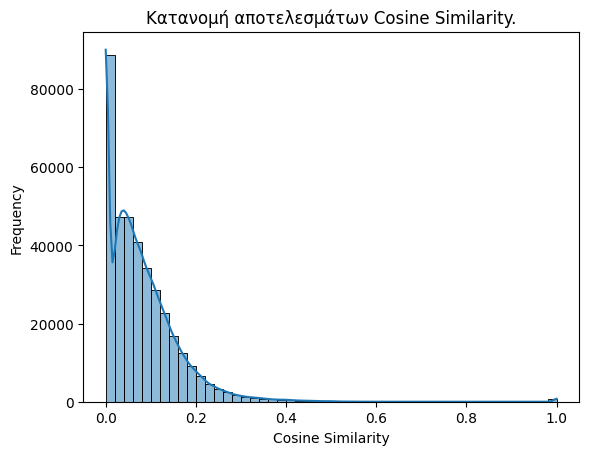

In [18]:
sns.histplot(cos_sim.flatten(), bins=50, kde=True)
plt.title("Κατανομή αποτελεσμάτων Cosine Similarity.")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


In [19]:
# create a sparse csr_matrix for easier fitting.
user_to_movie_csr = csr_matrix(train_rating_matrix.values)
dense_matrix = user_to_movie_csr.toarray()
print(dense_matrix)                                                                                       

[[4. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
def baseline_model():
    return 3.0

def CF_user_mean(user_id, movie_id, user_similarity, train_rating_matrix):
    #check if the movie_id exists in the train_rating_matrix
    if movie_id not in train_rating_matrix.columns:
        return 3.0  #default value if movie_id is not found
    
    #get the ratings for the movie from all users
    movie_ratings = train_rating_matrix[movie_id]
    
    #filter out users who haven't rated the movie
    valid_ratings = movie_ratings[movie_ratings > 0]
    
    #if no valid ratings, return a default value (example 3.0)
    if len(valid_ratings) == 0:
        return 3.0
    
    #return the mean rating
    return valid_ratings.mean()


def CF_user_wmean(user_id, movie_id, cos_sim, train_rating_matrix, k=20):
    """
    Collaborative Filtering using weighted mean
    
    cos_sim: precomputed user-user cosine similarity matrix
    k: number of most similar users to consider
    return: predicted rating for the user-movie pair
    """
    #check if the movie_id exists in the user_to_movie_ratings
    if movie_id not in train_rating_matrix.columns:
        return 3.0  #default value if movie_id is not found
    
    # get the user similarity scores with all other users
    user_sim_scores = cos_sim[user_id-1]  #adjust for 0-based index
    
    #get the ratings for the movie from all users
    movie_ratings = train_rating_matrix[movie_id]
    
    #filter out users who haven't rated the movie
    valid_ratings_mask = movie_ratings > 0
    valid_ratings = movie_ratings[valid_ratings_mask]
    valid_sim_scores = user_sim_scores[valid_ratings_mask]
    
    #if no valid ratings, return a default value
    if len(valid_ratings) == 0:
        return 3.0
    
    #sort by similarity and select top-k similar users
    top_k_indices = np.argsort(valid_sim_scores)[-k:]
    
    # access values by integer location
    top_k_ratings = valid_ratings.iloc[top_k_indices]
    top_k_sim_scores = valid_sim_scores[top_k_indices]
    
    #compute the weighted mean of the top-k ratings
    if top_k_sim_scores.sum() == 0:
        return valid_ratings.mean()  #back to mean if no similarity
    else:
        return np.dot(top_k_ratings, top_k_sim_scores) / top_k_sim_scores.sum()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def score(CF_model, user_similarity, train_rating_matrix, threshold=3.5):
    """
    Evaluate the collaborative filtering model using RMSE
    
    CF_model: the collaborative filtering model function
    user_similarity: precomputed user-user similarity matrix
    train_rating_matrix: the user-item rating matrix
    return: dict containing RMSE
    """
    #get user-movie pairs from the test set
    id_pairs = zip(X_test['userId'], X_test['movieId'])
    
    #generate predictions
    y_pred = np.array([CF_model(user_id, movie_id, user_similarity, train_rating_matrix) for (user_id, movie_id) in id_pairs])
    y_true = np.array(X_test['rating'])
    
    #compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    #convert ratings to binary classes
    y_true_binary = (y_true >= threshold).astype(int)
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    #compute classification metrics
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    
    #return metrics as a dictionary
    return {
        'RMSE': rmse,
        'F1-score': f1,
        'Accuracy': accuracy,
        'Recall': recall
    }

metrics_mean = score(CF_user_mean, None, train_rating_matrix)
metrics_cosine = score(CF_user_wmean, cos_sim, train_rating_matrix)
metrics_pearson = score(CF_user_wmean, user_correlation, train_rating_matrix)


metrics_comparison = pd.DataFrame({
    'Simple Mean': metrics_mean,
    'Cosine Similarity': metrics_cosine,
    'Pearson Correlation': metrics_pearson
})

print(metrics_comparison)


          Simple Mean  Cosine Similarity  Pearson Correlation
RMSE         0.977406           0.970870             1.326566
F1-score     0.702273           0.704145             0.706614
Accuracy     0.653703           0.658460             0.659729
Recall       0.666365           0.663131             0.668564


## Εκπαίδευση του KNN μοντέλου, για την δημιουργία του Συστήματος Συστάσεων.

In [21]:
knn_model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_model.fit(dense_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

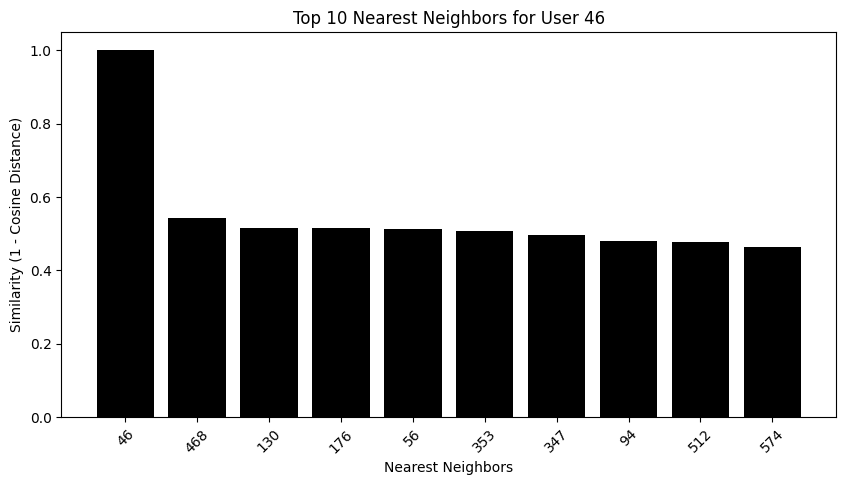

In [22]:
user_index = train_rating_matrix.index.get_loc(46)

knn_input = train_rating_matrix.values[user_index].reshape(1, -1)
distances, indices = knn_model.kneighbors(knn_input, n_neighbors=10)


plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), 1 - distances.flatten(), color='black')
plt.xlabel("Nearest Neighbors")
plt.ylabel("Similarity (1 - Cosine Distance)")
plt.title(f"Top 10 Nearest Neighbors for User {user_index+1}")
plt.xticks(range(1, 11), indices.flatten()+1, rotation=45)
plt.show()

### User and Movie Based algorithms.

In [28]:
# find most similar users to the input user (user-based)
def find_similar_users(user_id, n = 10):
    if user_id not in train_rating_matrix.index:
        print(f"User: {user_id} not found in training data.")
        return [], []
    user_index = train_rating_matrix.index.get_loc(user_id)
    knn_input = train_rating_matrix.values[user_index].reshape(1, -1)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n)

    similar_users = train_rating_matrix.index[indices.flatten()[1:]].tolist()
    similar_distances = distances.flatten()[1:].tolist()
    
    print("Οι πρώτοι", n ,"χρήστες που μοιάζουν με τον χρήστη", user_id , "είναι: ")
    for i in range(1,len(distances[0])):
        print(i,". Χρήστης:", indices[0][i]+1, "μοιάζει με απόσταση: ", (1 - distances[0][i]))
    return similar_users, similar_distances

def find_similar_movies(movie_id, n=10):
    pass



In [27]:
def movies_recommender(user_id, CF_Model, top_n):
    similar_users, user_distance = CF_Model

    user_movies = set(X_train[X_train['userId'] == user_id]['movieId'])
    movies_to_recommend = pd.DataFrame(columns=['title', 'movieId', 'movie_weight', 'genres'])
    for i, sim_user in enumerate(similar_users):
        sim_movies = X_train[X_train['userId'] == sim_user]

        sim_movies = sim_movies[~sim_movies['movieId'].isin(user_movies)]

        for _, row in sim_movies.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            weight = 1 / (user_distance[i] + 1e-5)
            weighted_rating = rating*weight

            movies_to_recommend = pd.concat([movies_to_recommend, pd.DataFrame({'title': movies[movies['movieId'] == movie_id]['title'] ,'movieId': [movie_id], 'movie_weight': [weighted_rating], 'genres': movies[movies['movieId'] == movie_id]['genres']})], ignore_index=True)

    movies_to_recommend = movies_to_recommend.loc[movies_to_recommend.groupby('movieId')['movie_weight'].idxmax()]
    movies_to_recommend = movies_to_recommend.sort_values(by='movie_weight', ascending=False)[:top_n]
    return movies_to_recommend

In [ ]:
user_id = 46
#movies_list = train_user_movie_ratings.columns

recommended_movies = movies_recommender(user_id, find_similar_users(user_id), 20)
recommended_movies.head(50)

Οι πρώτοι 10 χρήστες που μοιάζουν με τον χρήστη 46 είναι: 
1 . Χρήστης: 468 μοιάζει με απόσταση:  0.5433537579304775
2 . Χρήστης: 130 μοιάζει με απόσταση:  0.5166340815020909
3 . Χρήστης: 176 μοιάζει με απόσταση:  0.5163216301658067
4 . Χρήστης: 56 μοιάζει με απόσταση:  0.5118163242665894
5 . Χρήστης: 353 μοιάζει με απόσταση:  0.5076012402428008
6 . Χρήστης: 347 μοιάζει με απόσταση:  0.4958985993983712
7 . Χρήστης: 94 μοιάζει με απόσταση:  0.4809691604069759
8 . Χρήστης: 512 μοιάζει με απόσταση:  0.4766481051221704
9 . Χρήστης: 574 μοιάζει με απόσταση:  0.46412432814361604


/tmp/ipykernel_3471/327009677.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  movies_to_recommend = pd.concat([movies_to_recommend, pd.DataFrame({'title': movies[movies['movieId'] == movie_id]['title'] ,'movieId': [movie_id], 'movie_weight': [weighted_rating], 'genres': movies[movies['movieId'] == movie_id]['genres']})], ignore_index=True)


,title,movieId,movie_weight,genres
7,Clueless (1995),39,10.949155,Comedy|Romance
0,Seven (a.k.a. Se7en) (1995),47,10.949155,Mystery|Thriller
20,"Rock, The (1996)",733,10.337234,Action|Adventure|Thriller
15,Terminator 2: Judgment Day (1991),589,10.337234,Action|Sci-Fi
16,Tombstone (1993),553,10.337234,Action|Drama|Western
45,Jurassic Park (1993),480,10.241837,Action|Adventure|Sci-Fi|Thriller
77,Nine Months (1995),186,10.154165,Comedy|Romance
61,Hoop Dreams (1994),246,10.154165,Documentary
56,Murder in the First (1995),280,10.154165,Drama|Thriller
69,Shallow Grave (1994),319,10.154165,Comedy|Drama|Thriller


In [25]:
print(f'\n10 ταινίες που είδε ο χρήστης: {user_id}.')
user_watched_movies = dataset[(dataset['userId'] == user_id) & (dataset['rating'] > 1)].sort_values(by="rating", ascending=False).head(30)
user_watched_movies


10 ταινίες που είδε ο χρήστης: 46.


,userId,movieId,rating,title,genres
6876,46,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6887,46,173,5.0,Judge Dredd (1995),Action|Crime|Sci-Fi
6916,46,593,5.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
6914,46,590,5.0,Dances with Wolves (1990),Adventure|Drama|Western
6913,46,588,5.0,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
6912,46,457,5.0,"Fugitive, The (1993)",Thriller
6911,46,454,5.0,"Firm, The (1993)",Drama|Thriller
6907,46,380,5.0,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
6905,46,364,5.0,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
6902,46,339,5.0,While You Were Sleeping (1995),Comedy|Romance


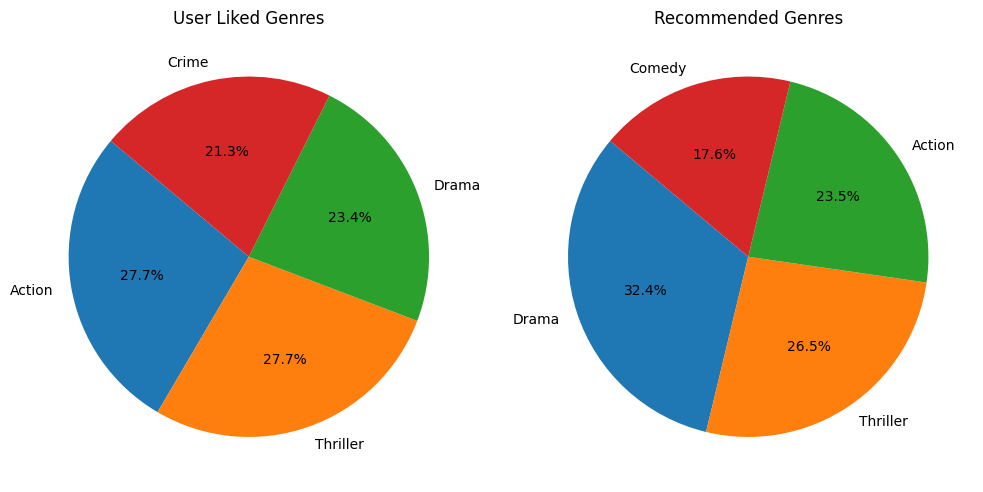

In [26]:
genre_counts1 = user_watched_movies['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
genre_counts2 = recommended_movies['genres'].str.get_dummies(sep='|').sum().sort_values(ascending=False)
labels=('User Liked Genres', 'Recommended Genres')
# Get top N genres and group the rest as "Other"
top_genres1 = genre_counts1[:4]
top_genres2 = genre_counts2[:4]

other_genres1 = genre_counts1[5:].sum()
other_genres2 = genre_counts2[5:].sum()

genre_labels1 = list(top_genres1.index)
genre_labels2 = list(top_genres2.index)

genre_values1 = list(top_genres1.values)
genre_values2 = list(top_genres2.values)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].pie(genre_values1, labels=genre_labels1, autopct='%1.1f%%', startangle=140)
axes[0].set_title(labels[0])

axes[1].pie(genre_values2, labels=genre_labels2, autopct='%1.1f%%', startangle=140)
axes[1].set_title(labels[1])

plt.tight_layout()
plt.show()